# Aligning signals from Music Lab mobile app trials

Experiment form of 16 trials of mixed stimuli and tasks (sitting in quiet, hearing music, talking, movement to music, select actions), on two participants and two phone positions each. 

Participant Movement recorded via three systems: 
1) Delsys motion capture system using ten markers
2) Sweetzpost respiration belt
3) Mobile phone accelerometer via MusicLab app

First task for assessing these signals is to align them to a common time frame. 

Details of trial recordings and file associations found at https://docs.google.com/spreadsheets/d/1lYFBzKTXrPHs2XA_qx7OVUX4a90C_PziQQ634WtA-7E/edit?usp=sharing

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## reinterpolate and filter signals for alignment

First load related files of a single trial

KB_T4	T6.mp3	KB_Trial_04Redo.tsv	1615899714492	data_part2_trial_4_Stim_T6.csv	
Resp start	Mobile start	Stim
6	8	13

In [2]:
# conditions for comparison 246900 289766
units = 1000 # ms
fs = 10/units # 10 Hz

cutoff = np.array([0.5])/units # filtering to between 1 and 0.05 hz
nyq = 1 * fs 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

In [3]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
trail_wise = pd.read_csv('trial_wise.csv')
trail_seq = pd.read_csv('Trial_Stim.csv')
trial_times=trail_seq.iloc[:,:2].copy()

trial_times['Time (ms)'] = units*trial_times['Time (s)']
trial_times=trial_times.set_index("Time (ms)", drop=True)

In [4]:
# trial timing information
trial_n =8

# Trial to test
trial_name = trail_wise.loc[trial_n,'Participant'] + '_' + trail_wise.loc[trial_n,'Trial stim']

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
mob = pd.read_csv(trail_wise.loc[trial_n,'Mobile_file'])

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/' + str(trail_wise.loc[trial_n,'Resp_file']) + '/')
filename = 'Breathing2.csv'
g = pd.read_csv(filename,',',header=None,names=['0','1','2','3','4','5'])
resp_init = g.loc[g['1']=='force']
respdelay = np.round(resp_init.iloc[0,0] - g.iloc[0,0],-2)
print('resp belt sensor connection delay ' + str(respdelay/1000) + 's' ) #rounded to 10 hz

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
m = pd.read_csv(trail_wise.loc[trial_n,'mocap_file'], sep='\t',header=None,names=['HEADT X', 'HEADT Y', 'HEADT Z', 'SHL X', 'SHL Y','SHL Z','SHR X', 'SHR Y', 'SHR Z','CH X', 'CH Y', 'CH Z'])
mocap = m.loc[~m['CH Z'].isna(),:].copy()#.astype(float)
mocap = mocap.iloc[1:,:]
mocap.loc[:,'Time (ms)'] = (np.arange(0,len(mocap),)*units/120) - trail_wise.loc[trial_n,'Stim']*units
trail_wise.loc[trial_n,:]

resp belt sensor connection delay 4.1s


filename                       KB_Trial_01.qtm
Data type                               Mocap 
Resp start                                 5.0
Mobile start                              10.0
Stim                                        23
Trial stim                                  T1
Participant                                 KB
Trial order                                  9
Mobile loc                                   6
Music Move                            Standing
Move Act                              Clapping
Resp_file                        1615898127612
Mobile_file     data_part2_trial_1_Stim_T1.csv
mocap_file                     KB_Trial_01.tsv
Name: 8, dtype: object

In [5]:
# set time to stim zero (approx) OLD
mob['Time (ms)'] = (mob['time']-mob['time'].loc[0])-(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Mobile start'])*units # Time is time zero

df = mob
#cols = list(mob.columns)
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']

time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)-np.median(f(time_new))
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mob_rs = df_rs.copy()

In [6]:
theta = np.pi*2*25/360
theta

0.4363323129985824

In [7]:
# set time to stim zero (approx)
mob['Time (ms)'] = (mob['time']-mob['time'].loc[0])-(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Mobile start'])*units # Time is time zero

df = mob
#cols = list(mob.columns)
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']

time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)-np.median(f(time_new))
theta = np.pi*2*25/360 # phone angle, estimated
df_rs['MOB X'] = df_rs['x']*np.cos(theta) + df_rs['z']*np.sin(theta)
df_rs['MOB Z'] = -df_rs['x']*np.sin(theta) + df_rs['z']*np.cos(theta)

cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma','MOB X','MOB Z']
for c in cols:
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mob_rs = df_rs.copy()
mob_rs.loc[30000:60000].corr()

,Time (s),x,y,z,alpha,beta,gamma,MOB X,MOB Z,filt x,...,filt alpha,diff alpha,filt beta,diff beta,filt gamma,diff gamma,filt MOB X,diff MOB X,filt MOB Z,diff MOB Z
Time (s),1.000000,-0.502965,-0.159066,-0.393618,-0.008033,0.071332,-0.032199,-0.491230,-0.280018,-0.577932,...,-0.063983,0.117351,0.236953,0.138998,-0.093403,0.083577,-0.544978,0.184893,-0.405050,0.174581
x,-0.502965,1.000000,-0.169798,0.749417,-0.027633,-0.083946,-0.000624,0.963199,0.513741,0.897819,...,0.131316,-0.147529,0.084218,-0.510749,0.093705,-0.144019,0.895021,-0.004851,0.833073,0.100649
y,-0.159066,-0.169798,1.000000,-0.192708,0.040947,-0.037189,0.001334,-0.190123,-0.172053,-0.092838,...,0.091799,0.467389,-0.066063,0.075029,-0.029705,0.503620,-0.122930,-0.046380,-0.214098,-0.145414
z,-0.393618,0.749417,-0.192708,1.000000,-0.020049,0.238473,-0.064386,0.899803,0.953050,0.826854,...,0.071148,-0.115527,0.107692,-0.529897,0.088660,-0.169356,0.845905,-0.077794,0.858313,0.039502
alpha,-0.008033,-0.027633,0.040947,-0.020049,1.000000,0.184789,-0.149949,-0.026348,-0.013341,0.018838,...,0.299298,-0.002082,0.012116,0.025935,0.023410,-0.047253,0.014407,0.041224,-0.000934,0.026898
beta,0.071332,-0.083946,-0.037189,0.238473,0.184789,1.000000,-0.046709,0.041495,0.347406,0.030550,...,0.036797,-0.060879,0.442281,-0.007048,0.142183,-0.161546,0.033294,0.409126,0.040303,0.393913
gamma,-0.032199,-0.000624,0.001334,-0.064386,-0.149949,-0.046709,1.000000,-0.026550,-0.083145,0.032695,...,0.058094,0.073123,0.135327,0.160612,0.525263,-0.012365,0.031929,0.107699,0.027540,0.131096
MOB X,-0.491230,0.963199,-0.190123,0.899803,-0.026348,0.041495,-0.026550,1.000000,0.725442,0.927302,...,0.115416,-0.144116,0.099216,-0.551684,0.097741,-0.163656,0.933193,-0.034779,0.897409,0.082360
MOB Z,-0.280018,0.513741,-0.172053,0.953050,-0.013341,0.347406,-0.083145,0.725442,1.000000,0.660816,...,0.032136,-0.082227,0.101030,-0.453048,0.072029,-0.153584,0.686782,-0.098587,0.731193,0.005155
filt x,-0.577932,0.897819,-0.092838,0.826854,0.018838,0.030550,0.032695,0.927302,0.660816,1.000000,...,0.175543,-0.123914,0.076241,-0.453032,0.150278,-0.132146,0.995844,-0.023372,0.923506,0.072946


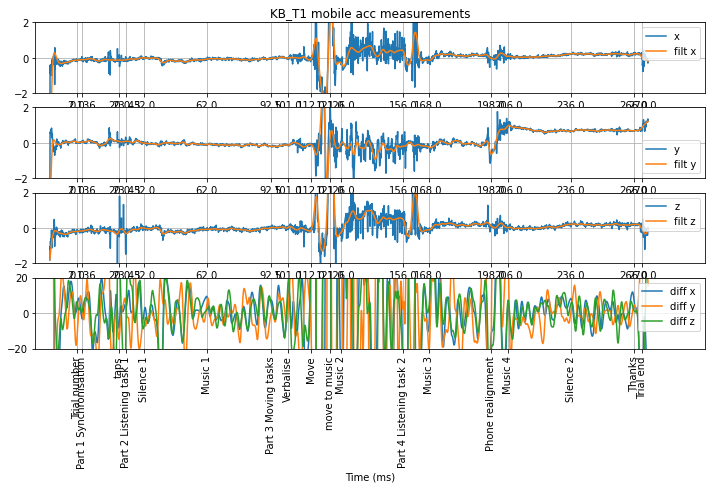

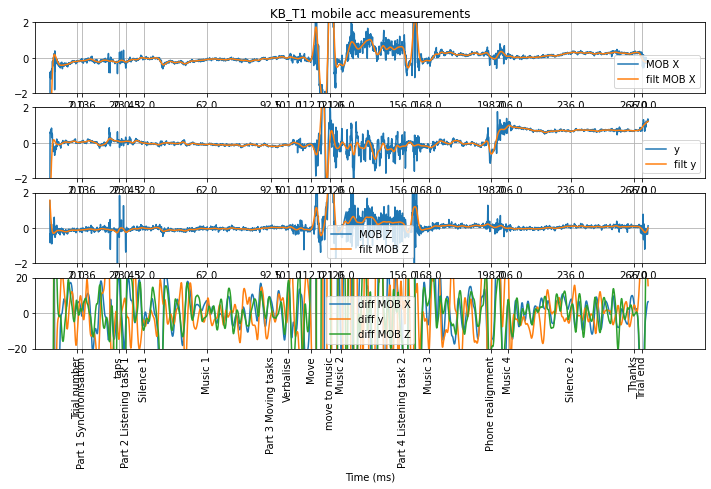

In [8]:
t_range = np.array([-20,300])*units
fig = plt.figure(figsize=(12,6))
dims = ['x', 'y', 'z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-2,2)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    if i == 0: plt.title(trial_name + ' mobile acc measurements')

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xlim(t_range)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()

plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])

plt.savefig('filtered_Mobile.png',dpi = 200)
plt.show()

t_range = np.array([-20,300])*units
fig = plt.figure(figsize=(12,6))
dims = ['MOB X', 'y', 'MOB Z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-2,2)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    if i == 0: plt.title(trial_name + ' mobile acc measurements')

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xlim(t_range)
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()

plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])

plt.savefig('filtered_Mobile_rot.png',dpi = 200)
plt.show()

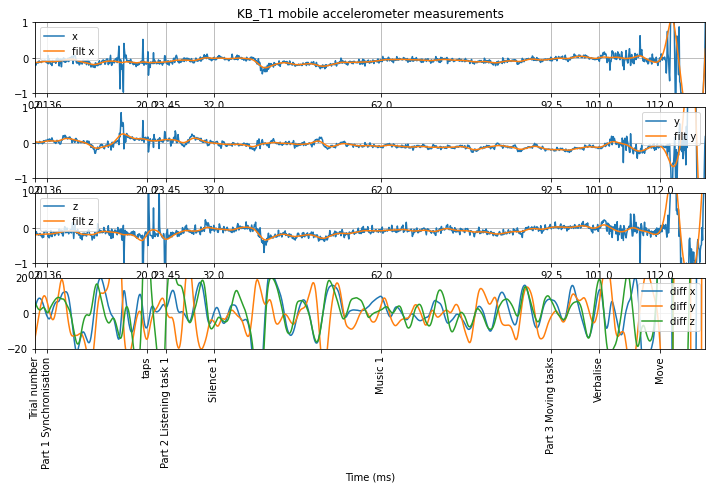

In [9]:
t_range = np.array([0,120])*units
fig = plt.figure(figsize=(12,6))
dims = ['x', 'y', 'z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-1,1)
    if i == 0: plt.title(trial_name + ' mobile accelerometer measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

plt.savefig('filtered_Mobile_ex_' + trial_name + '.png',dpi = 200)
plt.show()


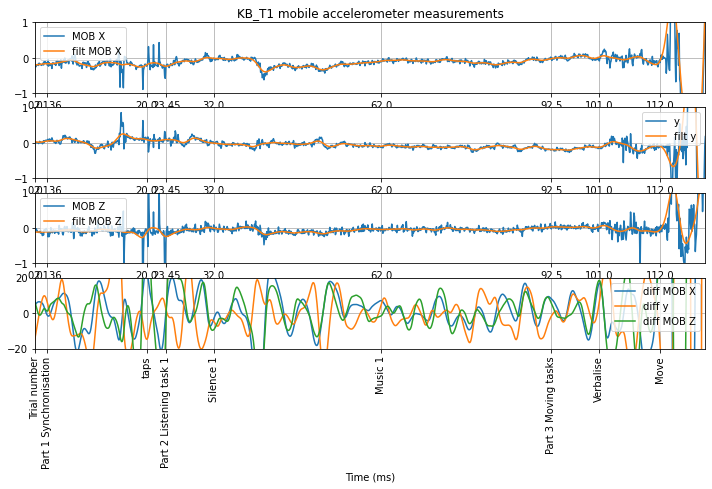

In [10]:
t_range = np.array([0,120])*units
fig = plt.figure(figsize=(12,6))
dims = ['MOB X', 'y', 'MOB Z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-1,1)
    if i == 0: plt.title(trial_name + ' mobile accelerometer measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-20,20)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)

plt.savefig('filtered_Mobile_ROT_ex_' + trial_name + '.png',dpi = 200)
plt.show()


In [12]:
resp = pd.DataFrame()
resp['belt'] = resp_init['3']
resp['Time (ms)'] = respdelay+(resp_init['5']-resp_init.iloc[0,5]) -(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Resp start'])*units
df = resp.copy()
#cols = list(mob.columns)
cols = ['belt']
print(cols)

time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c]) - np.median(filtfilt(b, a, df_rs[c]))
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

resp_rs = df_rs.copy()
resp_rs
# time_new
# df['Time (ms)']

['belt']


,Time (s),belt,filt belt,diff belt
Time (ms),,,,
-13900.0,-13.9,1929.0,316.389066,-27.903795
-13800.0,-13.8,1913.0,301.784418,-28.001894
-13700.0,-13.7,1906.0,287.128515,-27.951443
-13600.0,-13.6,1900.0,272.576585,-27.599438
-13500.0,-13.5,1896.0,258.288509,-26.937578
...,...,...,...,...
276000.0,276.0,1801.0,141.723052,1.770123
276100.0,276.1,1777.0,142.331683,0.638624
276200.0,276.2,1761.0,142.390382,-0.318782


In [13]:
respdelay+(resp_init['5']-resp_init.iloc[0,5]) -(trail_wise.loc[trial_n,'Stim']-trail_wise.loc[trial_n,'Resp start'])*units

4       -13900.0
5       -13800.0
6       -13700.0
7       -13600.0
8       -13500.0
          ...   
3564    276100.0
3565    276200.0
3566    276300.0
3567    276400.0
3568    276500.0
Name: 5, Length: 2905, dtype: float64

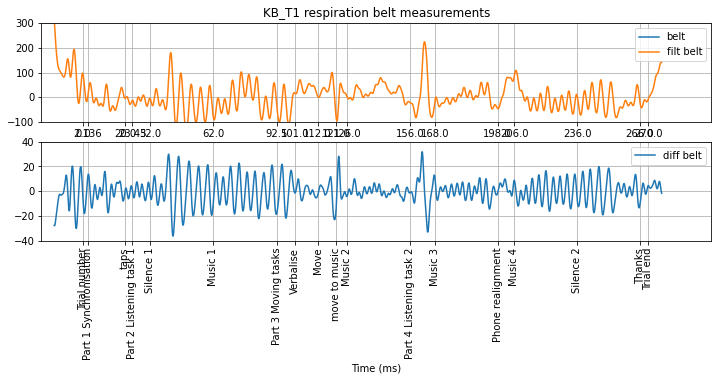

In [14]:
t_range = np.array([-20,300])*units
fig = plt.figure(figsize=(12,4))
dims = ['belt']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(211 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-100,300)
    if i == 0: plt.title(trial_name + ' respiration belt measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
ax = plt.subplot(212)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-40,40)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
plt.savefig('filtered_Resp.png',dpi = 300)
plt.show()


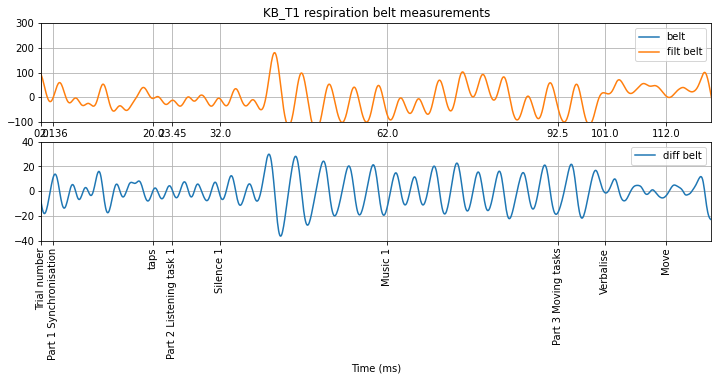

In [15]:
t_range = np.array([0,120])*units
fig = plt.figure(figsize=(12,4))
dims = ['belt']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(211 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.ylim(-100,300)
    if i == 0: plt.title(trial_name + ' respiration belt measurements')
    plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
    
ax = plt.subplot(212)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.ylim(-40,40)
    plt.xticks(trial_times.index,trial_times.Element, rotation='vertical')#, concert_times['event'])
    plt.grid()
    plt.xlim(t_range)
plt.savefig('filtered_Resp_ex_' + trial_name + '.png',dpi = 200)
plt.show()


In [16]:
# TODO rotate CH ZY to be closer to the mobile XY according to the recorded angles of the phone. 

In [17]:
df = mocap.copy()#.astype(float)
cols = df.columns
time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000

for c in cols[:-1]:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])-np.median(filtfilt(b, a, df_rs[c]))
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mocap_rs = df_rs.copy()
mocap_rs

,Time (s),HEADT X,filt HEADT X,diff HEADT X,HEADT Y,filt HEADT Y,diff HEADT Y,HEADT Z,filt HEADT Z,diff HEADT Z,...,diff SHR Z,CH X,filt CH X,diff CH X,CH Y,filt CH Y,diff CH Y,CH Z,filt CH Z,diff CH Z
Time (ms),,,,,,,,,,,,,,,,,,,,,
-23000.0,-23.0,-117.110,17.124186,-42.598784,-83.576,14.769105,-73.364815,1305.000,4.018346,-3.118844,...,26.252926,-92.222,7.783385,-74.547694,-236.566,-7.529027,-110.917591,1034.928,15.928701,-44.257547
-22900.0,-22.9,-115.640,16.180335,-37.385224,-84.786,12.668665,-69.741208,1305.114,3.996213,-6.283842,...,28.620147,-91.439,7.051513,-75.191617,-237.191,-8.945915,-111.125540,1034.240,15.371956,-44.029467
-22800.0,-22.8,-115.613,15.359530,-31.524620,-87.098,10.674595,-65.411924,1304.589,3.959180,-9.848662,...,30.942918,-91.072,6.313347,-75.722142,-238.440,-10.365458,-110.855522,1033.520,14.818089,-43.522812
-22700.0,-22.7,-117.237,14.692311,-24.277343,-89.681,8.828327,-59.623335,1304.420,3.903482,-14.294420,...,33.128414,-91.752,5.571102,-75.949873,-240.272,-11.775455,-109.590153,1032.742,14.274124,-42.459061
-22600.0,-22.6,-118.869,14.213591,-15.462353,-93.343,7.174106,-52.289145,1304.176,3.824589,-19.796417,...,35.070561,-92.579,4.828484,-75.713210,-242.126,-13.162699,-107.255181,1031.461,13.747089,-40.846839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282600.0,282.6,757.542,845.662168,1292.560139,653.162,780.453571,1882.952461,1608.981,289.879421,931.583908,...,-1186.693755,908.474,941.064257,3544.185185,606.089,826.128059,4569.464267,1329.818,298.075416,300.041855
282700.0,282.7,824.613,875.336387,1214.477382,746.982,834.760025,1803.526691,1624.381,293.757905,726.993537,...,-1228.980052,963.365,974.558391,3292.388671,702.684,883.336757,4363.504217,1340.693,301.337970,222.315346
282800.0,282.8,867.681,902.987909,1122.166023,848.921,886.338720,1697.318793,1630.855,296.724506,545.802826,...,-1239.354377,1002.290,1005.432324,3010.702165,797.556,937.504622,4094.157291,1348.107,303.683163,155.029710


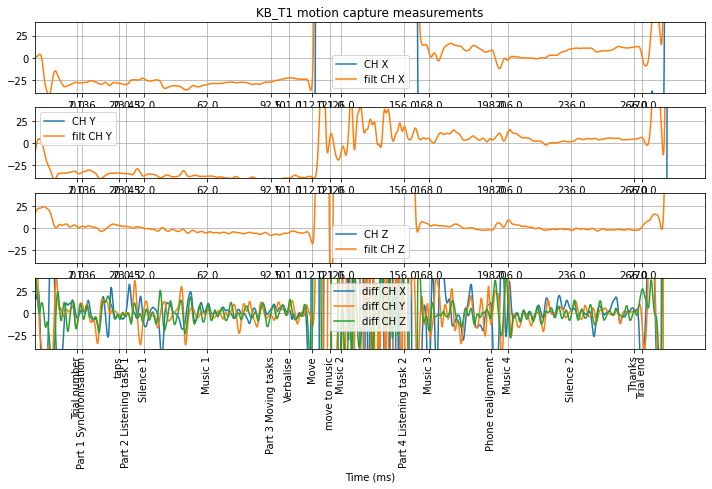

In [18]:
#t_range = np.array([0,120])*units
t_range = np.array([-20,300])*units
df_rs = mocap_rs
markers = ['CH']
dims = ['X','Y','Z']
for m in markers:
    fig = plt.figure(figsize=(12,6))
    for i in range(len(dims)):
        d = dims[i]
        ax = plt.subplot(411 + i)
        df_rs.plot.line(y= m + ' ' + d,ax=ax)
        df_rs.plot.line(y='filt ' + m + ' ' + d,ax=ax)
        plt.xlim(t_range)
        plt.ylim(-40,40)
        if i == 0: plt.title(trial_name + ' motion capture measurements')
        plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

    ax = plt.subplot(414)
    for d in dims:
        df_rs.plot.line(y='diff ' + m + ' ' + d,ax=ax)
        plt.ylim(-40,40)
        plt.xticks(trial_times.index,trial_times["Element"],rotation='vertical')#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

#plt.savefig('filtered_mocap_CH_ex_' + trial_name + '.png',dpi = 200)
plt.savefig('filtered_CH.png',dpi = 200)
plt.show()


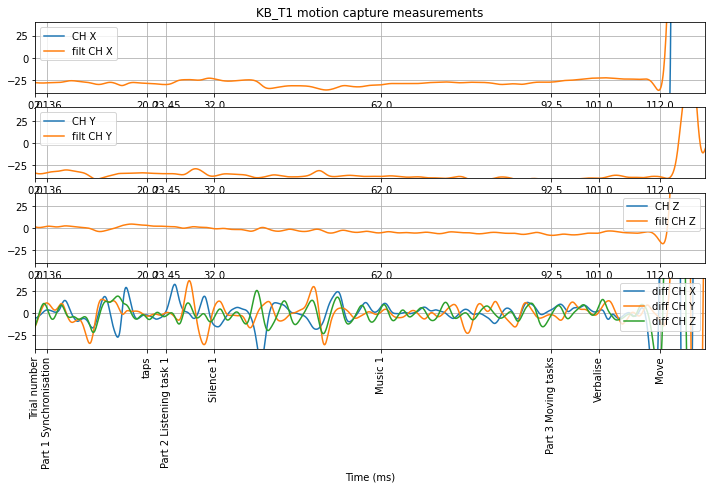

In [19]:
t_range = np.array([0,120])*units

df_rs = mocap_rs
markers = ['CH']
dims = ['X','Y','Z']
for m in markers:
    fig = plt.figure(figsize=(12,6))
    for i in range(len(dims)):
        d = dims[i]
        ax = plt.subplot(411 + i)
        df_rs.plot.line(y= m + ' ' + d,ax=ax)
        df_rs.plot.line(y='filt ' + m + ' ' + d,ax=ax)
        plt.xlim(t_range)
        plt.ylim(-40,40)
        if i == 0: plt.title(trial_name + ' motion capture measurements')
        plt.xticks(trial_times.index,trial_times["Time (s)"])#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

    ax = plt.subplot(414)
    for d in dims:
        df_rs.plot.line(y='diff ' + m + ' ' + d,ax=ax)
        plt.ylim(-40,40)
        plt.xticks(trial_times.index,trial_times["Element"],rotation='vertical')#, concert_times['event'])
        plt.grid()
        plt.xlim(t_range)

plt.savefig('filtered_mocap_CH_ex_' + trial_name + '.png',dpi = 200)

plt.show()


In [20]:
# 2892 2748
len(mob_rs)
len(mocap_rs)
len(resp_rs)

2904

# align mocap and mobile
compare chest location data with mobile movement to see if we can align them reliably 

In [102]:
seg_n = 14 # 4 # silence 1
print(trial_times.iloc[seg_n,:])
#these alignments can then be refined
M1_rs = mocap_rs.loc[trial_times.index[seg_n]:trial_times.index[seg_n+1],:]
#M1_rs['Time (s)'] = mocap['Time (ms)']/1000
M2_rs = resp_rs.loc[trial_times.index[seg_n]:trial_times.index[seg_n+1],:]
#mob_rs['sTime0'] = mob_rs.index - 3*units
M3_rs = mob_rs.loc[trial_times.index[seg_n]:trial_times.index[seg_n+1],:]
#mob_rs['sTime0'] = mob_rs.index - 3*units

# z normalise signals
cols= M1_rs.columns
for c in cols[1:]:
    M1_rs.loc[:,c] = (M1_rs[c]-M1_rs[c].mean())/M1_rs[c].std()
    
cols = M2_rs.columns
for c in cols[1:]:
    M2_rs.loc[:,c] = (M2_rs[c]-M2_rs[c].mean())/M2_rs[c].std()
M2_rs

cols = M3_rs.columns
for c in cols[1:]:
    M3_rs.loc[:,c] = (M3_rs[c]-M3_rs[c].mean())/M3_rs[c].std()

Time (s)      206.0
Element     Music 4
Name: 206000.0, dtype: object


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [103]:
M2_rs

,Time (s),belt,filt belt,diff belt
Time (ms),,,,
206000.0,206.0,1.027421,2.442734,1.096040
206100.0,206.1,1.345983,2.557246,1.053712
206200.0,206.2,1.393767,2.664470,0.968601
206300.0,206.3,1.401731,2.760035,0.848432
206400.0,206.4,1.338019,2.840509,0.701518
...,...,...,...,...
235600.0,235.6,0.907961,0.515179,0.418412
235700.0,235.7,0.796464,0.539407,0.132533
235800.0,235.8,0.692932,0.531849,-0.147553


In [104]:
cols= M1_rs.columns
print(cols[1:])
df = M1_rs[['CH X', 'filt CH X', 'diff CH X', 'CH Y',
       'filt CH Y', 'diff CH Y', 'CH Z', 'filt CH Z', 'diff CH Z']].copy()
cols= M2_rs.columns
print(cols)
df = df.join(M2_rs[cols[1:]])
cols= M3_rs.columns
print(cols)
df = df.join(M3_rs[['x', 'y', 'z', 'MOB Z', 'MOB X',
       'filt x', 'diff x', 'filt y', 'diff y', 'filt z', 'diff z',
       'filt MOB X', 'diff MOB X', 'filt MOB Z', 'diff MOB Z']])
df

Index(['HEADT X', 'filt HEADT X', 'diff HEADT X', 'HEADT Y', 'filt HEADT Y',
       'diff HEADT Y', 'HEADT Z', 'filt HEADT Z', 'diff HEADT Z', 'SHL X',
       'filt SHL X', 'diff SHL X', 'SHL Y', 'filt SHL Y', 'diff SHL Y',
       'SHL Z', 'filt SHL Z', 'diff SHL Z', 'SHR X', 'filt SHR X',
       'diff SHR X', 'SHR Y', 'filt SHR Y', 'diff SHR Y', 'SHR Z',
       'filt SHR Z', 'diff SHR Z', 'CH X', 'filt CH X', 'diff CH X', 'CH Y',
       'filt CH Y', 'diff CH Y', 'CH Z', 'filt CH Z', 'diff CH Z'],
      dtype='object')
Index(['Time (s)', 'belt', 'filt belt', 'diff belt'], dtype='object')
Index(['Time (s)', 'x', 'y', 'z', 'alpha', 'beta', 'gamma', 'MOB X', 'MOB Z',
       'filt x', 'diff x', 'filt y', 'diff y', 'filt z', 'diff z',
       'filt alpha', 'diff alpha', 'filt beta', 'diff beta', 'filt gamma',
       'diff gamma', 'filt MOB X', 'diff MOB X', 'filt MOB Z', 'diff MOB Z'],
      dtype='object')


,CH X,filt CH X,diff CH X,CH Y,filt CH Y,diff CH Y,CH Z,filt CH Z,diff CH Z,belt,...,filt x,diff x,filt y,diff y,filt z,diff z,filt MOB X,diff MOB X,filt MOB Z,diff MOB Z
Time (ms),,,,,,,,,,,,,,,,,,,,,
206000.0,-1.255315,-1.402440,1.865068,0.671622,2.153365,4.899268,0.227521,3.214420,1.651778,1.027421,...,-0.013215,0.390802,1.125377,4.286499,-0.037965,0.999013,-0.016677,0.696621,-0.059012,1.096570
206100.0,-1.119307,-1.327623,2.415590,0.826002,2.272334,4.372612,0.239429,3.239839,0.884768,1.345983,...,0.002131,0.290546,1.172904,3.752043,-0.000534,0.979029,0.008351,0.626235,-0.015487,1.107781
206200.0,-0.983759,-1.238316,2.876554,0.980017,2.375657,3.762816,0.247447,3.241101,0.116875,1.393767,...,0.014538,0.140758,1.212795,3.114978,0.035085,0.884672,0.030695,0.491505,0.027044,1.044685
206300.0,-0.820364,-1.137346,3.230071,1.060193,2.461212,3.084505,0.247294,3.218422,-0.634961,1.401731,...,0.022912,-0.056391,1.243848,2.395796,0.066909,0.733034,0.048842,0.301593,0.066418,0.927662
206400.0,-0.676816,-1.027983,3.462978,1.110439,2.527366,2.357881,0.249060,3.172591,-1.351514,1.338019,...,0.026142,-0.298518,1.265140,1.615869,0.093517,0.540287,0.061488,0.065369,0.101250,0.775878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235600.0,1.165460,2.593800,0.092067,-0.221961,-0.540078,0.498807,0.007169,-1.026350,-0.682270,0.907961,...,1.986968,1.184263,-0.339510,-0.019504,2.102145,0.327331,2.166466,0.873259,1.860457,-0.019442
235700.0,1.178537,2.609183,0.041535,-0.232083,-0.534799,0.518602,0.004400,-1.060922,-0.596177,0.796464,...,2.022138,1.223855,-0.343866,0.093276,2.120561,0.410665,2.197284,0.935640,1.867874,0.069523
235800.0,1.185769,2.623232,-0.001812,-0.232010,-0.528971,0.538988,0.002616,-1.092431,-0.487679,0.692932,...,2.058165,1.256694,-0.346708,0.211607,2.141420,0.492892,2.229638,0.993390,1.878203,0.159538


In [105]:

trial_times.index[4]

32000.0

In [106]:
M2a_rs = M2_rs.copy()
M2a_rs['Time 2'] = M2a_rs.index+np.round(np.amax(xc)) 
M2a_rs = M2a_rs.set_index('Time 2',drop = False)
M2a_rs

,Time (s),belt,filt belt,diff belt,Time 2
Time 2,,,,,
206252.0,206.0,1.027421,2.442734,1.096040,206252.0
206352.0,206.1,1.345983,2.557246,1.053712,206352.0
206452.0,206.2,1.393767,2.664470,0.968601,206452.0
206552.0,206.3,1.401731,2.760035,0.848432,206552.0
206652.0,206.4,1.338019,2.840509,0.701518,206652.0
...,...,...,...,...,...
235852.0,235.6,0.907961,0.515179,0.418412,235852.0
235952.0,235.7,0.796464,0.539407,0.132533,235952.0
236052.0,235.8,0.692932,0.531849,-0.147553,236052.0


In [107]:
M3_rs = mob_rs.loc[trial_times.index[seg_n]:trial_times.index[seg_n+1],:]
theta = 45
M3_rs['Mob Z'] = M3_rs['x']*np.cos(theta) + M3_rs['z']*np.sin(theta)
M3_rs['Mob X'] = -M3_rs['x']*np.sin(theta) + M3_rs['z']*np.cos(theta)

M3_rs

<ipython-input-107-de3f645f78cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M3_rs['Mob Z'] = M3_rs['x']*np.cos(theta) + M3_rs['z']*np.sin(theta)
<ipython-input-107-de3f645f78cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M3_rs['Mob X'] = -M3_rs['x']*np.sin(theta) + M3_rs['z']*np.cos(theta)


,Time (s),x,y,z,alpha,beta,gamma,MOB X,MOB Z,filt x,...,filt beta,diff beta,filt gamma,diff gamma,filt MOB X,diff MOB X,filt MOB Z,diff MOB Z,Mob Z,Mob X
Time (ms),,,,,,,,,,,,,,,,,,,,,
206000.0,206.0,-0.640958,1.262666,-0.282347,-2.054858,-1.303203,-1.567011,-0.474474,-0.133358,-0.013215,...,2.171258,-0.823308,-1.746209,4.938170,-0.016677,0.696621,-0.059012,1.096570,-0.576959,0.397070
206100.0,206.1,1.559718,2.391334,0.841328,-3.088860,2.909241,-1.782507,1.246472,0.510975,0.002131,...,2.047897,-1.210513,-0.890244,5.259006,0.008351,0.626235,-0.015487,1.107781,1.535243,-0.885201
206200.0,206.2,-1.585032,1.637695,0.807415,-1.908169,1.767787,0.281371,-0.461800,1.322179,0.014538,...,1.882935,-1.545181,0.004457,5.396655,0.030695,0.491505,0.027044,1.044685,-0.145620,1.772862
206300.0,206.3,1.075239,1.870450,0.283022,-3.428154,-0.245788,-0.860322,0.719056,0.026518,0.022912,...,1.683468,-1.805738,0.905940,5.336023,0.048842,0.301593,0.066418,0.927662,0.805671,-0.766247
206400.0,206.4,0.240775,1.962473,0.225953,-2.754305,0.420410,1.806079,0.242798,0.188804,0.026142,...,1.459255,-1.978050,1.780592,5.071868,0.061488,0.065369,0.101250,0.775878,0.318748,-0.086179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235600.0,235.6,1.527826,-0.661910,1.481446,0.218762,0.584766,0.108073,1.535134,1.224915,1.986968,...,0.554445,-0.535543,-0.333910,-0.070696,2.166466,0.873259,1.860457,-0.019442,2.063168,-0.521796
235700.0,235.7,1.674318,-0.515637,1.221952,0.404125,-0.090571,-0.008192,1.489980,0.899454,2.022138,...,0.481154,-0.628946,-0.341809,-0.097306,2.197284,0.935640,1.867874,0.069523,1.919319,-0.782765
235800.0,235.8,1.867944,-0.515300,1.216358,-0.290848,0.459718,-0.141052,1.591491,0.841043,2.058165,...,0.398374,-0.699941,-0.354456,-0.127507,2.229638,0.993390,1.878203,0.159538,2.016276,-0.950460


['diff CH Z', 'diff belt', 265.60506999709753, 289, 601, 60100.0]


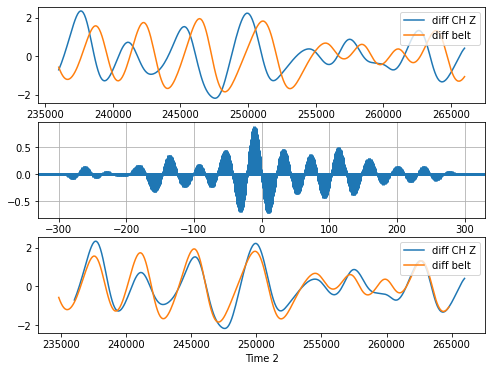

In [39]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
#print(cols1)
cols2 = M2_rs.columns
#print(cols2)
C1 = 'diff CH Z'
C2 = 'diff belt'#cols2[2]
length = np.min([len(M1_rs),len(M2_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
M1_rs.plot.line(y=C1,ax=ax1)
M2_rs.plot.line(y=C2,ax=ax1)

ax2 = plt.subplot(312)
ax2.xcorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], usevlines=True, maxlags=np.min([length-1,600]), normed=True, lw=3)
ax2.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], "full")
print([C1, C2, np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid

M2a_rs = M2_rs.copy()
M2a_rs['Time 2'] = M2a_rs.index+np.round(-(len(xc)/2) + np.argmax(xc,axis=0))*100
M2a_rs = M2a_rs.set_index('Time 2',drop = False)

ax1 = plt.subplot(313)
M1_rs.plot.line(y = C1,ax=ax1)
M2a_rs.plot.line(y = C2,ax=ax1)
ax.grid(True)

['diff CH Z', 'diff belt', 204.30783070438008, 289, 601, 60100.0]


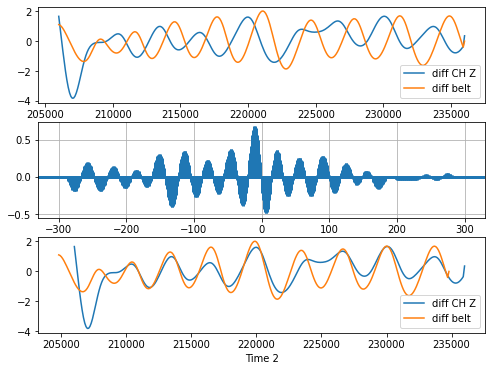

In [119]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
#print(cols1)
cols2 = M2_rs.columns
#print(cols2)
C1 = 'diff CH Z'
C2 = 'diff belt'#cols2[2]
length = np.min([len(M1_rs),len(M2_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
M1_rs.plot.line(y=C1,ax=ax1)
M2_rs.plot.line(y=C2,ax=ax1)

ax2 = plt.subplot(312)
ax2.xcorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], usevlines=True, maxlags=np.min([length-1,600]), normed=True, lw=3)
ax2.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], "full")
print([C1, C2, np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid

M2a_rs = M2_rs.copy()
M2a_rs['Time 2'] = M2a_rs.index+np.round(-(len(xc)/2) + np.argmax(xc,axis=0))/fs
M2a_rs = M2a_rs.set_index('Time 2',drop = False)

ax1 = plt.subplot(313)
M1_rs.plot.line(y = C1,ax=ax1)
M2a_rs.plot.line(y = C2,ax=ax1)
ax.grid(True)

In [117]:
1/fs

100.0

['diff CH Z', 'filt z', 157.80058540188625, 305, 601, 60100.0]


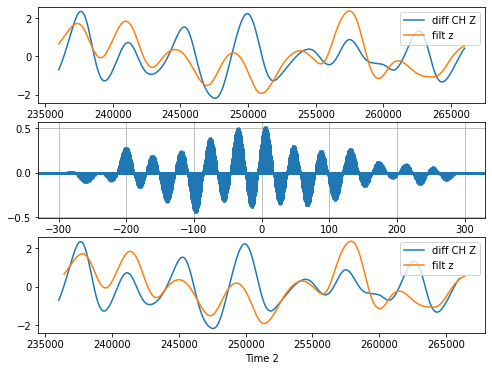

In [42]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
#print(cols1)
cols2 = M3_rs.columns
#print(cols2)
C1 = 'diff CH Z'
C2 = 'filt z'#cols2[2]
length = np.min([len(M1_rs),len(M3_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
M1_rs.plot.line(y=C1,ax=ax1)
M3_rs.plot.line(y=C2,ax=ax1)

ax2 = plt.subplot(312)
ax2.xcorr(M1_rs[C1].iloc[:length],M3_rs[C2].iloc[:length], usevlines=True, maxlags=np.min([length-1,600]), normed=True, lw=3)
ax2.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M3_rs[C2].iloc[:length], "full")
print([C1, C2, np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid

M3a_rs = M3_rs.copy()
M3a_rs['Time 2'] = M3a_rs.index+np.round(-(len(xc)/2) + np.argmax(xc,axis=0))*100
M3a_rs = M3a_rs.set_index('Time 2',drop = False)

ax1 = plt.subplot(313)
M1_rs.plot.line(y = C1,ax=ax1)
M3a_rs.plot.line(y = C2,ax=ax1)
ax.grid(True)

['diff CH Z', 'diff z', 0.32412819416577326, 97.23845824973196, 251, 601, 60100.0]


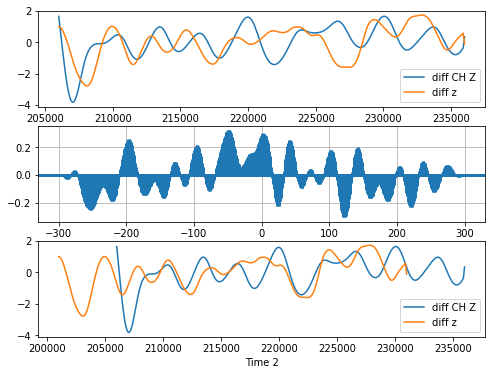

In [114]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
#print(cols1)
cols2 = M3_rs.columns
#print(cols2)
C1 = 'diff CH Z'
C2 = 'diff z'#cols2[2]
length = np.min([len(M1_rs),len(M3_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
M1_rs.plot.line(y=C1,ax=ax1)
M3_rs.plot.line(y=C2,ax=ax1)

ax2 = plt.subplot(312)
a = ax2.xcorr(M1_rs[C1].iloc[:length],M3_rs[C2].iloc[:length], usevlines=True, maxlags=np.min([length-1,600]), normed=True, lw=3)
ax2.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M3_rs[C2].iloc[:length], "full")
print([C1, C2, a[1].max(),np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid

M3a_rs = M3_rs.copy()
M3a_rs['Time 2'] = M3a_rs.index+np.round(-(len(xc)/2) + np.argmax(xc,axis=0))*100
M3a_rs = M3a_rs.set_index('Time 2',drop = False)

ax1 = plt.subplot(313)
M1_rs.plot.line(y = C1,ax=ax1)
M3a_rs.plot.line(y = C2,ax=ax1)
ax.grid(True)




##### 15
# ['diff CH Z', 'diff z', 0.6684673990757071, 200.54021972271215, 275, 601, 60100.0]
# ['diff CH Z', 'diff MOB Z', 0.645501791436389, 193.6505374309167, 276, 601, 60100.0]

# ['diff CH X', 'diff MOB X', 0.6272001359767216, 188.16004079301652, 311, 601, 60100.0]
# ['diff CH X', 'diff x', 0.5825186881122655, 174.75560643367967, 311, 601, 60100.0]
# ['filt CH X', 'filt MOB X', 0.5764404431686682, 172.93213295060045, 315, 601, 60100.0]
# ['filt CH X', 'filt x', 0.5605279986095025, 168.15839958285076, 314, 601, 60100.0]

# ['filt CH Y', 'filt y', 0.6129071336050259, 183.87214008150784, 302, 601, 60100.0]
# ['diff CH Y', 'diff y', 0.6579543892174661, 197.38631676523983, 301, 601, 60100.0]

######### 4
# ['diff CH Y', 'diff y', 0.7659690364520635, 229.79071093561907, 303, 601, 60100.0]
# ['filt CH Y', 'filt y', 0.6477429062611013, 194.32287187833046, 305, 601, 60100.0]

# ['filt CH X', 'filt x', 0.8939479456374245, 268.18438369122737, 305, 601, 60100.0]
# ['diff CH X', 'diff x', 0.8631906479637187, 258.9571943891156, 305, 601, 60100.0]
# ['diff CH X', 'diff MOB X', 0.8799234456277143, 263.9770336883142, 305, 601, 60100.0]
# ['filt CH X', 'filt MOB X', 0.8879162732704976, 266.3748819811493, 305, 601, 60100.0]

# ['filt CH Z', 'filt MOB Z', 0.44482053992512866, 133.4461619775386, 370, 601, 60100.0]
# ['diff CH Z', 'diff MOB Z', 0.5336476831079958, 160.0943049323987, 317, 601, 60100.0]
# ['diff CH Z', 'diff z', 0.5197561798221284, 155.92685394663852, 317, 601, 60100.0]
# ['filt CH Z', 'filt z', 0.4697076497603275, 140.91229492809828, 370, 601, 60100.0]

###### 5
# ['diff CH X', 'diff x', 0.6164548006639129, 188.01871420249344, 312, 611, 61100.0]
# ['diff CH X', 'diff MOB X', 0.6297814027407663, 192.08332783593372, 311, 611, 61100.0]
# ['filt CH X', 'filt MOB X', 0.781989781724562, 238.50688342599133, 305, 611, 61100.0]
# ['filt CH X', 'filt x', 0.8249562018699318, 251.6116415703292, 305, 611, 61100.0]

##### 14
# *['filt CH X', 'filt x', 0.8417580999601512, 252.52742998804536, 299, 601, 60100.0]
# ['diff CH X', 'diff x', 0.3434167444815483, 103.02502334446449, 308, 601, 60100.0]
# ['diff CH X', 'diff MOB X', 0.46749493437953143, 140.24848031385943, 307, 601, 60100.0]
# *['filt CH X', 'filt MOB X', 0.8885577549486544, 266.56732648459626, 299, 601, 60100.0]
# ['diff CH Z', 'diff MOB Z', 0.30732529043989865, 92.1975871319696, 252, 601, 60100.0]
# ['diff CH Z', 'diff z', 0.32412819416577326, 97.23845824973196, 251, 601, 60100.0]
# ['diff CH Z', 'diff z', 0.32412819416577326, 97.23845824973196, 251, 601, 60100.0]

## need a long interval than 30 sec to check quality of alignment with diff x diff CH X and
## the fact that different combinations of signals produce different optimal alignments
#  is a big worry here. Need a stable offset estimate.
# can do seated silence and music for music onw

In [61]:
[a[1].max()]

[0.645501791436389, -0.6387378350290294]

In [40]:
M3_rs.columns

Index(['Time (s)', 'x', 'y', 'z', 'alpha', 'beta', 'gamma', 'MOB X', 'MOB Z',
       'filt x', 'diff x', 'filt y', 'diff y', 'filt z', 'diff z',
       'filt alpha', 'diff alpha', 'filt beta', 'diff beta', 'filt gamma',
       'diff gamma', 'filt MOB X', 'diff MOB X', 'filt MOB Z', 'diff MOB Z',
       'Mob Z', 'Mob X'],
      dtype='object')

In [46]:
xc

array([-7.51595809e-03, -3.03207983e-03,  1.05417861e-02,  3.03236632e-02,
        5.34535000e-02,  7.70749671e-02,  9.83093697e-02,  1.14231568e-01,
        1.21856337e-01,  1.18142932e-01,  1.00018420e-01,  6.44038029e-02,
        8.22652149e-03, -7.15875116e-02, -1.78145282e-01, -3.14638004e-01,
       -4.84399625e-01, -6.90947891e-01, -9.37974800e-01, -1.22925936e+00,
       -1.56849717e+00, -1.95907455e+00, -2.40383673e+00, -2.90488212e+00,
       -3.46337475e+00, -4.07934355e+00, -4.75145987e+00, -5.47683425e+00,
       -6.25089193e+00, -7.06736857e+00, -7.91844234e+00, -8.79498756e+00,
       -9.68690557e+00, -1.05834817e+01, -1.14737307e+01, -1.23467025e+01,
       -1.31917468e+01, -1.39987530e+01, -1.47583738e+01, -1.54622175e+01,
       -1.61029981e+01, -1.66746491e+01, -1.71724136e+01, -1.75929311e+01,
       -1.79343369e+01, -1.81963597e+01, -1.83803842e+01, -1.84894571e+01,
       -1.85282355e+01, -1.85028842e+01, -1.84209256e+01, -1.82910461e+01,
       -1.81228618e+01, -

In [ ]:
np.amax(xc)

In [ ]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


In [ ]:
cols1 = M1_rs.columns
print(cols1)
cols2 = M2_rs.columns

C2 = cols2[3]
print(C2)
for C1 in cols1:
    d1 = M1_rs[C1].iloc[:length]
    d2 = M2_rs[C2].iloc[:length]
    seconds = 15
    fps = 10
    #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

    offset = np.floor(len(rs)/2)-np.argmax(rs)
    r = np.max(rs)

    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'{C1} {C2} Offset = {offset} frames with r = {r} \nS1 leads <> S2 leads',ylim=[-.75,.75], xlabel='Offset',ylabel='Pearson r')
    #ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    #ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt.legend()
    plt.show()

In [ ]:
cols1 = M1_rs.columns
cols2 = M2_rs.columns
alignments = pd.DataFrame()

for C2 in cols2[1:10]:
    for C1 in cols1[:-1]:
        d1 = M1_rs[C1].iloc[:length]
        d2 = M2_rs[C2].iloc[:length]
        seconds = 15000
        fps = 1/100
        lagmax = 10 # int(seconds*fps+1)
        #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rs = [d1.corr(d2.shift(lag)) for lag in range(-lagmax,lagmax)]

        offset = np.floor(len(rs)/2)-np.argmax(rs)
        r = np.max(rs)
        alignments= alignments.append({'S1':C1,'S2':C2,'offset (s)':offset/fps,'r': r},ignore_index=True)
alignments

In [ ]:
range(-int(seconds*fps),int(seconds*fps+1))

In [ ]:
alignments.max()
np.argmax(alignments['r'])

In [ ]:
alignments.loc[40]

# Alignment testing 
Compare the signals take from the respiration belt and the mobile device and the motion capture measurements (CH and HEADT).


first to align,
Then to evaluate share in formation. 

In [ ]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 9*units
resp_rs['sTime0'] = resp_rs.index - 5*units
mob_rs['sTime0'] = mob_rs.index - 3*units


In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

In [ ]:
compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor
st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

d_Range.corr()
#sp.stats.pearsonr(DRB['Raw'],DRB['CH Z'])[0]
# sp.stats.pearsonr(d_Range['diff belt'],d_Range['diff CH Z'])[0]


In [ ]:
st = 0
et = st + 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
d_Range.corr()

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 0*units
resp_rs['sTime0'] = resp_rs.index + 113100 #0*units
#mob_rs['sTime0'] = mob_rs.index - 0*units

compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
#compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor

st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'filt x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'diff x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
# plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 20000
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:

df_sig = mocap['CH Z']
# interpolate to a workable comparison frame
f = interpolate.interp1d(mocap['Time'], df_sig.values,fill_value='extrapolate')
DMC = pd.DataFrame(index=resp['Time'])
DMC['CH Z'] = (f(DMC.index)-np.mean(abs(df_sig.values)))/np.mean(abs(df_sig.values))
DRB = respy.diffed(respy.respnormed(DMC))

df_sig.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.ylim(950,1000)
DMC.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.show()
DRB.plot(figsize=(10,3))
#plt.xlim(0,60)

# filter for comparison to resp belt 

# segments of stimuli


In [ ]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
filename = 'Trial recording - Trial Stimuli details.tsv'
stim_dets = pd.read_csv(filename,sep='\t')
filename = 'Trial recording - Qualisys_data.tsv'
rough_align = pd.read_csv(filename,sep='\t')

In [ ]:
stim_dets

In [ ]:
rough_align

In [ ]:
# trial timing information
trialno = 0 # 12
part_code = rough_align.loc[trialno,'Participant']
Trial_stim = rough_align.loc[trialno,'Trial stim']
Mob_Loc = rough_align.loc[trialno,'Mobile loc']
Move_Act = rough_align.loc[trialno,'Move Act']
Dance_Con = rough_align.loc[trialno,'Music Move']
Trial_Ord = rough_align.loc[trialno,'Trial order']

# Trial to test
trial_name = "DS_T1"

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
filename = 'data_part1_trial_1_Stim_T1.csv'
mob = pd.read_csv(filename)

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/1615819583587/')
filename = 'Breathing.txt'
g = pd.read_csv(filename,' ',header=None)
resp = g.loc[g[8]=='true']

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
filename = 'DS_T1_redoLabeled2.tsv'
mocap = pd.read_csv(filename, sep='\t',skiprows=10)

In [ ]:
df_sTev = pd.DataFrame()

df_sTev['Element'] = stim_dets['Element']
df_sTev['qTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]
df_sTev['qTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[12]
df_sTev['mTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['mTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['rTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev['rTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev

In [ ]:
# pull out the signal segment corresponding to each element
time_cues = ['qTs','qTe']
df_QoM_seg = pd.DataFrame()
df_QoM_seg['Element'] = df_sTev['Element']
for marker in ["HEADT","SHL","SHR","CH"]:
    df_QoM_seg[marker] = 0
    for i in range(len(df_QoM_seg)-1):
        seg = mocap_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,[marker +' X',marker +' Y',marker +' Z']]
        a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
        dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
        df_QoM_seg.loc[i,marker] = a.sum()/dur 
    # get the average per marker
    i = 17
    seg = mocap_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,[marker +' X',marker +' Y',marker +' Z']]
    a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur  
    # normalise
#    df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['mTs','mTe']
marker = 'Mobile'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = mob_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,['x','y','z']]
    a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = mob_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,['x','y','z']]
a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur 
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['rTs','rTe']
marker = 'Resp'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = resp_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,'belt']
    a = seg.diff().abs()
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = resp_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,'belt']
a = seg.diff().abs()
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur    
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

df_QoM_seg.loc[i,'Element'] = 'Trial Average'

In [ ]:
cs = df_QoM_seg.columns
data2 = df_QoM_seg[cs[1:]]
corr = data2.corr(method="spearman")
sns.heatmap(corr)
corr

In [ ]:
df_QoM_seg['Participant'] = rough_align.loc[trialno,'Participant']
df_QoM_seg['Trial stim'] = rough_align.loc[trialno,'Trial stim']
df_QoM_seg['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
df_QoM_seg['Move Act'] = rough_align.loc[trialno,'Move Act']
df_QoM_seg['Music Move'] = rough_align.loc[trialno,'Music Move']
df_QoM_seg['Trial order'] = rough_align.loc[trialno,'Trial order']
df_QoM_seg['Trial Name'] = trial_name

corr['Participant'] = rough_align.loc[trialno,'Participant']
corr['Trial stim'] = rough_align.loc[trialno,'Trial stim']
corr['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
corr['Move Act'] = rough_align.loc[trialno,'Move Act']
corr['Music Move'] = rough_align.loc[trialno,'Music Move']
corr['Trial order'] = rough_align.loc[trialno,'Trial order']
corr['Trial Name'] = trial_name
corr['corrx'] = corr.index

# add segments to df_QoM_all
df_QoM_all = df_QoM_all.append(df_QoM_seg, ignore_index=True)
df_corrs_QoM = df_corrs_QoM.append(corr, ignore_index=True)



In [ ]:
df_QoM_all

In [ ]:
df_corrs_QoM

In [ ]:
df_QoM_all = pd.DataFrame()
df_corrs_QoM = pd.DataFrame()